# Task 2: Some Simple Spin Glasses

We'll now investigate some simple spin glasses. Your goal is to devise a thermal annealing schedule to find the ground state of the given Ising Hamiltonian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common.ising_animator import IsingAnimator
from common.abstract_ising import AbstractIsing
from common.utils import exp_decay_schedule

%matplotlib inline

## 1D Random Bond Ising on a Periodic Chain

$$H = J \sum_{\langle ij \rangle} B_{ij} \sigma_i \sigma_j$$

where $B_{ij} = \pm 1$ which is selected randomly and independently for each bond nearest neighbour bond $ij$ when the model is initialized.

Due to the intrinsic randomness of the Hamiltonian parameters, it is generally quite difficult to find the ground state of this model. 

In [2]:
class RandomBondIsing1DPBC(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.bonds = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
    def energy(self, spins=None):
        """Returns the energy of the current spin configuration"""
        spins = self.spins if spins is None else spins
        interactions = self.bonds * spins * np.roll(spins, 1, axis=-1)
        total = self.J * np.sum(interactions, axis=-1)
        return total

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        # sum the nearest neighbour sites
        
        nn_sum = (
            self.bonds[i] * self.spins[i-1] 
            + self.bonds[(i+1)%self.N] * self.spins[(i+1) % self.N] 
        )

        return -2 * self.J * self.spins[i] * nn_sum
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** self.num_spins)
        space = ((dim[:, None] & (1 << np.arange(self.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

In [3]:
ising = RandomBondIsing1DPBC(10, J=1)
print("Spins: ", ising.spins)
print("Bonds: ", ising.bonds)
print("Energy: ", ising.energy())

Spins:  [ 1  1 -1 -1  1 -1  1  1 -1 -1]
Bonds:  [ 1  1  1 -1  1 -1 -1  1  1 -1]
Energy:  -2


Let us run MC simulation at a fixed temperature ($T=1.0$) for 1000 iterations, and see what spin configuration the algorithm converges to

In [4]:
T = 1.0
n_steps = 1000

In [5]:
for t in range(n_steps):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print("Iteration %i, Energy=%i" % (t, E))
        
print("The final spin configuration: ", ising.spins)
print("The energy of the configuration: ", ising.energy())

Iteration 0, Energy=-6
Iteration 50, Energy=-6
Iteration 100, Energy=-10
Iteration 150, Energy=-10
Iteration 200, Energy=-6
Iteration 250, Energy=-6
Iteration 300, Energy=-6
Iteration 350, Energy=-10
Iteration 400, Energy=-10
Iteration 450, Energy=-6
Iteration 500, Energy=-10
Iteration 550, Energy=-10
Iteration 600, Energy=-10
Iteration 650, Energy=-6
Iteration 700, Energy=-10
Iteration 750, Energy=-10
Iteration 800, Energy=-6
Iteration 850, Energy=-10
Iteration 900, Energy=-10
Iteration 950, Energy=-10
The final spin configuration:  [ 1 -1  1 -1  1  1  1 -1 -1 -1]
The energy of the configuration:  -6


Let us now run the MC simulation for fixed temperature ($T=1.0$) for 1000 iterations once again, but this time using our `IsingAnimator` functionality, so that we can animate the evolution

[ 1  1  1 -1 -1 -1  1  1 -1  1]


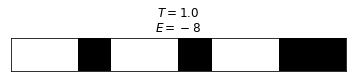

In [6]:
# reinitialize so we're back at a T=infinity state
ising = RandomBondIsing1DPBC(10, J=1)
print(ising.spins)  # print the starting configuration

# NOTE: sometimes the animation gets stuck displaying a single image
# The most reliable way to fix this is by restarting the notebook.
# Initializing the Ising Model in the same cell as the one where you
# run the animation also seems to work.
IsingAnimator(ising).run_animation([T] * n_steps)

Since the spin chain we have considered so far in this notebook is small (only 10 spins), instead of simulated annealing, we can do exact computation and find the exact minimal energy. For this purpose we need to calculate the energy of the chain for all possible spin configurations and pick the one(s) which give the lowest energy. Let us define a function `get_exact_minimum` which does this and return the exact minimal energy

In [7]:
ising.energy(ising.all_configurations()).min()

-8

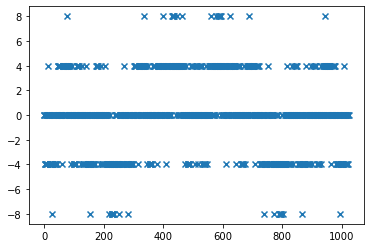

In [8]:
# plot the energy of all configurations
configurations = ising.all_configurations()
energies = ising.energy(configurations)
plt.scatter(np.arange(2 **ising.num_spins), energies, marker='x')

Now of course, we're limited in the size of the systems for which we can compute this energy exactly, hence why we need an annealing procedure which (we hope) would help us find the ground state of the Ising model of interest (or at least a state that is close enough).

Your task is to come up with an annealing procedure to help find the ground state (or something close enough) of this model for several different chain sizes: 10, 20, 50, 100.

For the small systems, compute the ground state energy exactly, and compare it to the result of your annealer.

Since it's impossible to find the exact ground state for large systems, you will be evaluated on your algorithm's performance on the small systems, as well as the overall ingenuity of your method.

Let us try the exponential time decay from the previous notebook, and see how does it work for this problem

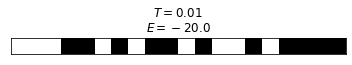

In [9]:
# your solution here
ising = RandomBondIsing1DPBC(20, J=1.)

T, _ = exp_decay_schedule(500, 100, 0.01)
animator = IsingAnimator(ising)
animator.run_animation(T)

In [10]:
# get exact minimum
ising.energy(ising.all_configurations()).min()

-20.0

# Fully Connected Random Bond Ising

The Fully Connected Random Bond Ising Hamiltonian takes the form:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j$$

where $B_{ij} = \pm 1$ which is selected randomly (uniformly) and independently for each bond $ij$ when the model is initialized.

In [11]:
class FullyConnectedRandomBondIsing(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = 2*(np.random.rand() < 0.5) - 1
    
    def energy(self, spins=None):
        """Returns the energy of the current spin configuration"""
        if spins is None:
            spins = self.spins
        
        if len(spins.shape) == 1:
            spins = spins[None, :]
        
        return np.einsum("bi,ij,bj->b", spins, ising.bonds, spins)
#         interaction = self.spins.dot(self.bonds.dot(self.spins))
#         return self.J * interaction

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        return -2 * self.J * self.spins[i] * (
            self.bonds[i, :].dot(self.spins) 
            + self.bonds[:, i].dot(self.spins)
        )
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** ising.num_spins)
        space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

In [12]:
ising = FullyConnectedRandomBondIsing(10, J=1)
print("Spins: ", ising.spins)
# print("Bonds: ", ising.bonds)
print("Energy: ", ising.energy())

Spins:  [ 1  1  1  1 -1  1 -1 -1 -1  1]
Energy:  [-3.]


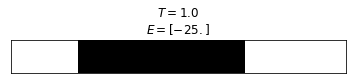

In [13]:
T = 1.0
n_steps = 1000

IsingAnimator(ising).run_animation([T] * n_steps)

In [15]:
# get the exact minimum
ising.energy(ising.all_configurations()).min()

-25.0

Repeat the previous problem with the Fully Connected Random Bond Ising Model for the same system sizes (10, 20, 50, 100).

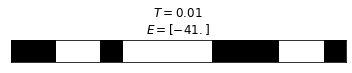

In [16]:
# your solution here
ising = FullyConnectedRandomBondIsing(15, J=1.)

T, _ = exp_decay_schedule(500, 100, 0.01)
animator = IsingAnimator(ising)
animator.run_animation(T)

In [17]:
# get the exact minimum
ising.energy(ising.all_configurations()).min()

-41.0

# The Fully Connected Mattis Model

Another model of interest is the Mattis Model which is a specific instance of a Random Bond Ising Model:

$$H = J\sum_{i<j} B_{ij}\sigma_i\sigma_j$$

however, the random bonds take the form:

$$B_{ij} = -\xi_i \xi_j$$

where $\xi_i = \pm 1$ with the sign selected randomly (uniformly) when the model is initialized.

In [19]:
class FullyConnectedMattisModel(FullyConnectedRandomBondIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.xi = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = -self.xi[i] * self.xi[j]
    

In [20]:
ising = FullyConnectedMattisModel(10, J=1)
ising.spins

array([ 1, -1, -1, -1, -1, -1, -1,  1, -1,  1])

In [21]:
ising.bonds

array([[ 0., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.],
       [ 0.,  0.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.],
       [ 0.,  0.,  0., -1., -1., -1.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  0.,  0., -1., -1.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [22]:
ising.energy()

-13.0

In [23]:
T = 0.1
# perform 1000 MC steps at low temperature to find the ground state
# it's fairly easy to find in this case as we'll discuss soon
for t in range(1000+1):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print(E)

-27.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0


In [24]:
ising.spins

array([ 1,  1, -1, -1, -1, -1,  1,  1, -1,  1])

In [25]:
dim = np.arange(2 ** ising.num_spins)
space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
space = 2*space.astype(int) - 1
np.einsum("bi,ij,bj->b", space, ising.bonds, space).min()

-45.0

While at first glance the `bonds` matrix for the Mattis Model appears to produce the glassy model, it is in fact not a glass at all. We can convert this into a simple fully connected Ising Model using a *gauge transformation*.
But first, make sure the MC simulation has converged to the ground state energy we computed exactly in the previous cell. If it hasn't done so yet, let it run a few more times.

Now let's look at our ground state spin configuration:

In [26]:
ising.spins

array([ 1,  1, -1, -1, -1, -1,  1,  1, -1,  1])

Next we'll look at the Mattis parameters $\xi$

In [27]:
ising.xi

array([-1, -1,  1,  1,  1,  1, -1, -1,  1, -1])

If we did indeed find the ground state, the spins should match with $\xi$ (upto a global sign). This gives us a hint as to what this Mattis Model actually is.

Let's look again at the Hamiltonian:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j = -J\sum_{i < j} \xi_i \xi_j \sigma_i \sigma_j = -J\sum_{i < j} (\xi_i \sigma_i) (\xi_j\sigma_j)$$

We introduce some new variables $s_i = \xi_i \sigma_i \in \lbrace 0, 1 \rbrace$. Then our Hamiltonian becomes:

$$H = -J \sum_{i < j} s_i s_j$$

which is just a fully connected Ising Model. If we compute $s_i$ for the state found in the previous simulation, we get:

In [28]:
ising.spins * ising.xi

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

which is one of the ground states of the fully connected Ising Model.

As an (unmarked) bonus problem, you can apply the annealing algorithm you developed in the two previous parts to this model. 
At the end of the annealing procedure, confirm that you've found the ground state by checking that $\xi_i$ is equal to $\sigma_i$ upto a global sign.